# Imports

In [9]:
import cv2
import numpy as np
import pandas as pd
from Misc.utils import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import argparse

import imutils
import random
import math
from scipy.interpolate import interp2d
import os

import dlib
%config Completer.use_jedi = False

# Functions

In [10]:
def DelauneyTriangles(Face2, Facemarks, box, colour = (0,255,255)):
    
    """
    get a List of triangles in the getTriangleList from subdiv2d and choose only the delauney triangles
    """
    
    Face = Face2.copy()
    #Create an instance of Subdiv2D with image dimensions 
    h,w = Face.shape[:2]    
    Box = (0, 0, w, h)
    subdiv = cv2.Subdiv2D(tuple(Box))


    # insert the points
    for point in Facemarks:
        subdiv.insert(tuple(point)) 

    triangleList = subdiv.getTriangleList()
    
    delTri = []
    MarkerInd = []
    ## for every triangle in the list
    for triangle in triangleList:

        ## get the vertices of the triangle
        a = (triangle[0], triangle[1])
        b = (triangle[2], triangle[3])
        c = (triangle[4], triangle[5])  
        vertices = [a,b,c]
        
        ## check if the triangle is inside the boundary box (or the image)
        boundaryCondition = isPointInside(a,Box) and isPointInside(b,Box) and isPointInside(c,Box)
        if  boundaryCondition:
            indices = []
            TrianglePoints = []
            ## find the facial markers that have a distance below 1.0 to the given vertice 
            for i,point in enumerate(Facemarks):
                for v in vertices :    
                    ##  find the points in the triangle list that corresponds to the facemarks
#                     if ((abs(v[0] - point[0]) < 1.0)  and ((abs(v[1] - point[1]) < 1.0))):
                    if (v[0] == point[0]) and (v[1] == point[1]) :
                        TrianglePoints.append(point)
                        indices.append(i)

            ## if there are exactly 3 points inside, then that is a delauney triangle                                                   
            if len(indices)==3:
                delTri.append(TrianglePoints)
                MarkerInd.append(indices[0])
                ## print delauney Triangles on the face
                a1,b1,c1 = tuple(TrianglePoints[0]),tuple(TrianglePoints[1]), tuple(TrianglePoints[2])
                Face = cv2.line(Face, a1, b1, colour, 1)
                Face = cv2.line(Face, b1, c1, colour, 1)
                Face = cv2.line(Face, c1, a1, colour, 1)    
    
    return delTri,MarkerInd, Face 

def FaceDetector(grayFace, box, FacePredictor = dlib.shape_predictor('./Misc/shape_predictor_68_face_landmarks.dat')):
    # pass the image and the bounding box to get face landmarks
    facemarks = FacePredictor(grayFace,box)
    facemarks = toNumpy(facemarks)
    BoundingBox = getcv2Box(box)
    (x,y,w,h) = BoundingBox
    shifted_FaceMarks = facemarks - (x,y)                
    return facemarks, BoundingBox, shifted_FaceMarks



# Pipeline

In [11]:
# for separate images :
path = "../Data/"
path1 = path+ "Face1.jpeg"
path2 =  path + "Face2.jpg"

## read the images..
Face1, Face2 = readImages(path1,path2)
grayFace1 = cv2.cvtColor(Face1, cv2.COLOR_BGR2GRAY)
grayFace2 = cv2.cvtColor(Face2, cv2.COLOR_BGR2GRAY)
#-----##

## load pretrained predictor and face detector
FacePredictor = dlib.shape_predictor('./Misc/shape_predictor_68_face_landmarks.dat')
detector =  dlib.get_frontal_face_detector()
#-----##

## get bounding box of face
N_pyrLayers = 1
box1 = detector(grayFace1,N_pyrLayers)[0]
box2 = detector(grayFace2,N_pyrLayers)[0]
#-----##

## detect the facial markers
facemarks1, BoundingBox1, shifted_FaceMarks1 = FaceDetector(grayFace1,box1)
facemarks2, BoundingBox2, shifted_FaceMarks2 = FaceDetector(grayFace2,box2)
#-----##

## to print the facial markers
# Face1_print = drawMarkers(Face1, facemarks1, BoundingBox1)
# Face2_print = drawMarkers(Face2, facemarks2, BoundingBox2)

## crop the face with the box, if needed..
# (x,y,w,h) = BoundingBox1
# Face1_crop  = Face1[y:y+h,x:x+w]
# (x,y,w,h) = BoundingBox2
# Face2_crop  = Face2[y:y+h,x:x+w]

## get the Delauney Triangles of the face
delTri1, tri_indices1, delFace1 = DelauneyTriangles(Face1, facemarks1, BoundingBox1)
delTri2,  tri_indices2, delFace2 = DelauneyTriangles(Face2, facemarks2, BoundingBox2)
#-----##

## find the common triangles in both faces using tri_indices

#-----##
## warp the pixels in every triangle in the source image to the destination image

#-----##
## do color equalization and blend

#-----##

112
113


# Workspace

- add to pipeline once the work is done
- add to functions once the functions are generated

In [12]:
len(delTri1),len(tri_indices1), len(delTri2),len(tri_indices2)

(112, 112, 113, 113)

In [5]:
id21 = tri_indices2.index(22)
id11 = tri_indices1.index(22) 

In [6]:
id11, id21

(48, 47)

In [7]:
Face_tri1 = PlotaTri(Face1, delTri1[id11])
Face_tri2 = PlotaTri(Face2, delTri2[id21])


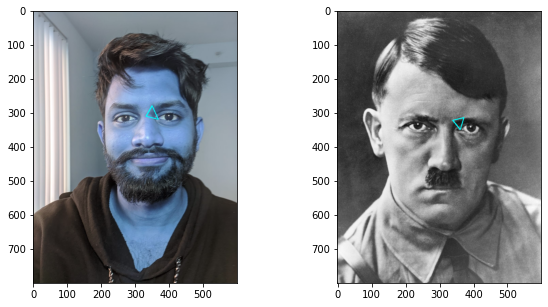

In [8]:

_, plts = plt.subplots(1,2,figsize=(10,5))
plts[0].imshow(Face_tri1)
plts[1].imshow(Face_tri2)

# Akath Functions

In [52]:
def features(img):
    #initialize facial detector
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.resize(gray,(300,300))
#     img = cv2.resize(img,(300,300))
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('./Misc/shape_predictor_68_face_landmarks.dat')
    rects = detector(gray,1)
    points = []
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(len(rects))
    for (i,rect) in enumerate(rects):
        
        shape = predictor(gray,rect)
        shape = face_utils.shape_to_np(shape)


        (x,y,w,h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

        for (x,y) in shape:
            cv2.circle(img,(x,y),2,(0,0,255),-1)
            points.append((x,y))
            
#         points = np.asarray(list([p.x, p.y] for p in shape.parts()), dtype=np.int)
    return points



# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    print(dst)

    return dst

def applyTransform(src,srcTri,dstTri,size):

    # print("src shape" + str(src.shape))
    # print("size" + str(size))

    t = dstTri
    s = srcTri

    r2 = cv2.boundingRect(np.float32([t]))

    xleft = r2[0]
    xright = r2[0] + r2[2]
    ytop = r2[1]
    ybottom = r2[1] + r2[3]
    # print(xleft,ytop,xright,ybottom)
    epsilon = 0.1
    barytransform = np.linalg.inv([[t[0][0],t[1][0],t[2][0]],[t[0][1],t[1][1],t[2][1]],[1,1,1]])     

    grid = np.mgrid[xleft:xright, ytop:ybottom].reshape(2,-1)
    #grid 2x608
    grid = np.vstack((grid, np.ones((1, grid.shape[1]))))
    #grid 3x608
    barycoords = np.dot(barytransform, grid)
    # print(len(barycoords[0])) 608
    t =[]
    b = np.all(barycoords>-epsilon, axis=0)
    a = np.all(barycoords<1+epsilon, axis=0)
    for i in range(len(a)):
        t.append(a[i] and b[i])
    # print(t.shape)
    dst_y = []
    dst_x = []
    for i in range(len(t)):
        if(t[i]):
            dst_y.append(i%r2[3])
            dst_x.append(i/r2[3])

            # print(i,i%r2[3],i%r2[2])

    # print(len(dst_x))
    # print(dst)

    # for i in range(len(barycoords[0])):
    #     print(np.sum(barycoords[:,i]))
    # temp = barycoords
    # barycoords = []
    # for b in temp:
    #     print(b)
    #     epsilon = 1e-5
    #     if (-epsilon<b[i]<1+epsilon for i in range(3))==[True,True,True]:
    #         barycoords.append(b)
    
    barycoords = barycoords[:,np.all(-epsilon<barycoords, axis=0)]
    barycoords = barycoords[:,np.all(barycoords<1+epsilon, axis=0)]
    # barycoords = barycoords[np.all(barycoords<1+epsilon)]

    
  
    trans = np.matrix([[s[0][0],s[1][0],s[2][0]],[s[0][1],s[1][1],s[2][1]],[1,1,1]])
    pts = np.matmul(trans,barycoords)
    
    xA = pts[0,:]/pts[2,:]
    yA = pts[1,:]/pts[2,:]

    dst = np.zeros((size[1],size[0],3), np.uint8)

    i = 0
    for x,y in zip(xA.flat,yA.flat):
        xs = np.linspace(0, src.shape[1], num=src.shape[1], endpoint=False)
        ys = np.linspace(0, src.shape[0], num=src.shape[0], endpoint=False)

        b = src[:, :, 0]
        fb = interp2d(xs, ys, b, kind='cubic')

        g = src[:, :, 1]
        fg = interp2d(xs, ys, g, kind='cubic')

        r = src[:, :, 2]
        fr = interp2d(xs, ys, r, kind='cubic')

        blue = fb(x, y)[0]
        green = fg(x, y)[0]
        red = fr(x, y)[0]

        dst[dst_y[i],dst_x[i]] = (blue,green,red)
        i = i+1
        # print(blue,green, red)

    return dst

def U(r):
    u = (r**2)*np.log(r**2)

    if(math.isnan(u)):
        # print("NaN")
        u = 0
    # else:
    #     print(u)

    return u


def estimate_params(points2,points1_d):

    p = len(points2)

    K = np.zeros((p,p), np.float32)
    P = np.zeros((p,3), np.float32)

    
    for i in range(p):
        for j in range(p):
            a = points2[i,:]
            b = points2[j,:]
            K[i,j] = U(np.linalg.norm((a-b)))

    P = np.hstack((points2,np.ones((p,1))))
    # print("here")
    
    A = np.hstack((P.transpose(),np.zeros((3,3))))
    B = np.hstack((K,P))
    C = np.vstack((B,A))
    lamda = 0.0000001

    T = np.linalg.inv(C + lamda*np.identity(p+3))
    # print(T.shape)
    
    target = np.concatenate((points1_d,[0,0,0]))
    # print(target.shape)

    params = np.matmul(T,target)

    # print(params.shape)

    return params

def TPS(img1,img2,points1,points2,hull2):

    points1 = np.asarray(points1)
    points2 = np.asarray(points2)
    p = len(points1)

    print(p)

    r = cv2.boundingRect(np.float32([points2]))
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)

    points2_t = []

    for i in range(len(hull2)):
        points2_t.append(((hull2[i][0]-r[0]),(hull2[i][1]-r[1])))

    cv2.fillConvexPoly(mask, np.int32(points2_t), (1.0, 1.0, 1.0), 16, 0);
    cv2.imshow("Mask",mask)
    cv2.waitKey(2000)
    cv2.destroyAllWindows()
    # print(points1[:,0])

    x_params = estimate_params(points2,points1[:,0])
    y_params = estimate_params(points2,points1[:,1])

    a1_x = x_params[p+2]
    ay_x = x_params[p+1]
    ax_x = x_params[p]

    a1_y = y_params[p+2]
    ay_y = y_params[p+1]
    ax_y = y_params[p]

    # print(img1.shape)
    warped_img = np.copy(mask)
    count = 0
    print(warped_img.shape)
    for i in range(warped_img.shape[1]):
        for j in range(warped_img.shape[0]):
            t = 0
            l = 0
            n = i+r[0]
            m = j+ r[1]
            b = [n,m]
            for k in range(p):
                a = points2[k,:]
                t = t+x_params[k]*U(np.linalg.norm((a-b)))
                l = l+y_params[k]*U(np.linalg.norm((a-b)))

            x = a1_x + ax_x*n + ay_x*m + t
            y = a1_y + ax_y*n + ay_y*m + l

            # print(count)
            # print(x,y)
            count += 1
            x = int(x)
            y = int(y)
            x = min(max(x, 0), img1.shape[1] - 1)
            y = min(max(y, 0), img1.shape[0] - 1)

            warped_img[j,i] = img1[y,x,:]

    cv2.imshow("warped_img",warped_img)
    cv2.waitKey(5000)
    cv2.destroyAllWindows()



    warped_img = warped_img * mask

    img2[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img2[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( (1.0, 1.0, 1.0) - mask )
    img2[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img2[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] + warped_img

    return img2

     


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri
        


# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    # print(t1)
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    # print(r1)
    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    # print("Mask shape = "+str(mask.shape))

    cv2.fillConvexPoly(mask, np.int32(t2Rect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    # img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    img2Rect = applyTransform(img1Rect, t1Rect, t2Rect, size)

    # print("img2rect shape =  "+str(img2Rect.shape))
    
    img2Rect = img2Rect * mask

    a = (1.0, 1.0, 1.0) - mask
    # print(a.shape)

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    

# Akath Implementation

In [53]:
filename1 = path = "../Data/Face1.jpeg"
filename2 = path = "../Data/Face2.jpg"

img1 = cv2.imread(filename1)
img2 = cv2.imread(filename2)

img1 = imutils.resize(img1,width = 320)
img2 = imutils.resize(img2,width = 320)

points1 = features(img1);
points2 = features(img2);

if len(points2)==0 or len(points1)==0:
    print("Face Not Detected")
    exit()

# Find convex hull
hull1 = []
hull2 = []

hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
# print(len(hullIndex))

for i in range(0, len(hullIndex)):
    hull1.append(points1[int(hullIndex[i])])
    hull2.append(points2[int(hullIndex[i])])



In [54]:
len(hull2)

21

In [72]:
# Find delanauy traingulation for convex hull points
img1Warped = img2.copy() 
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = calculateDelaunayTriangles(rect, hull2)

if len(dt) == 0:
    quit()
delTri1,delTri2 = [],[]
# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull1[dt[i][j]])
        t2.append(hull2[dt[i][j]])
    delTri1.append(np.array(t1).squeeze())
    delTri2.append(np.array(t2).squeeze())
    
    
#     warpTriangle(img1, img1Warped, t1, t2)


In [78]:
np.array(delTri2).shape

(19, 3, 2)

In [82]:
Face_tri1 = PlotaTri(Face1, delTri1[11])
Face_tri2 = PlotaTri(Face2, delTri2[11])


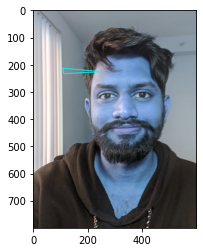

In [84]:
plt.imshow(Face_tri1)